   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

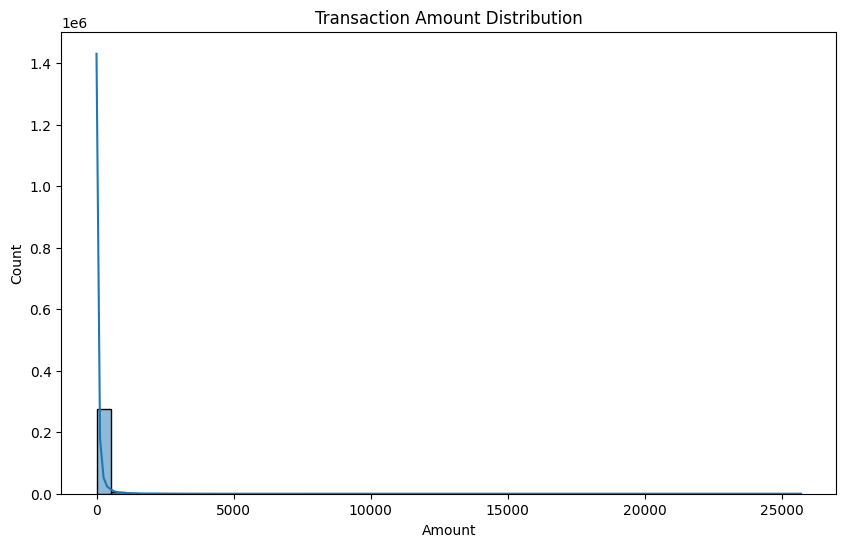

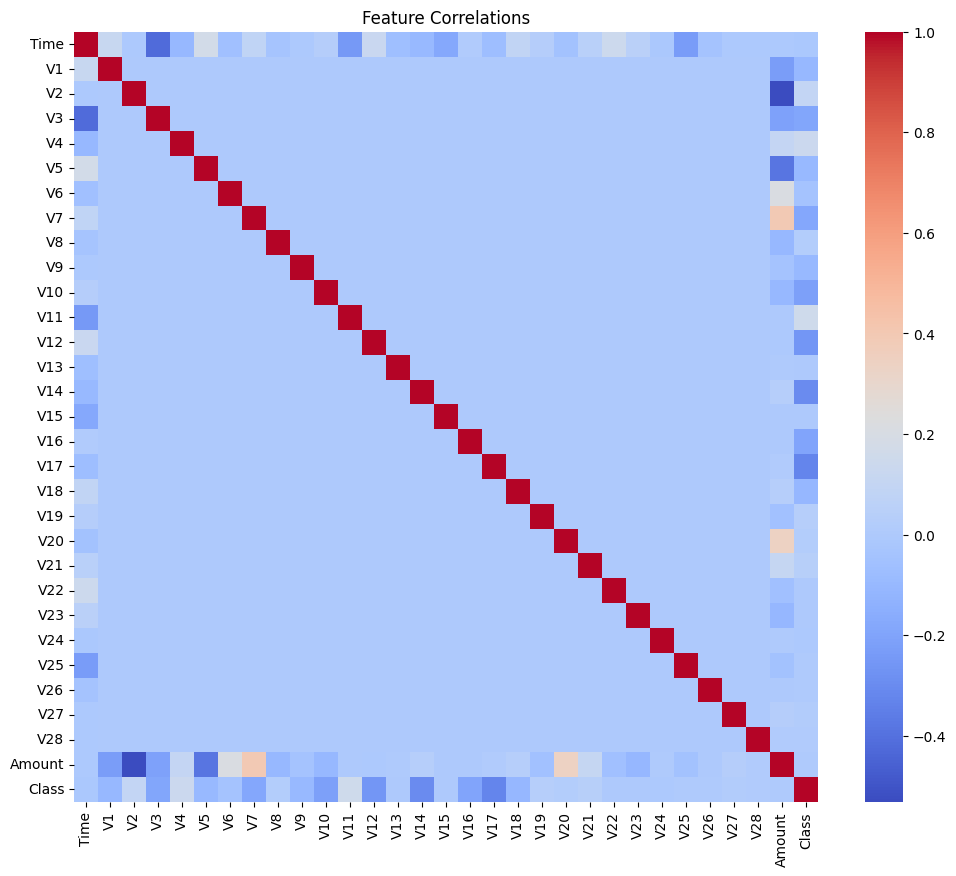

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('creditcard.csv')


print(df.head())
print(df.info())
print(df.describe())


print(df.isnull().sum())  


print(df['Class'].value_counts())



plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()


plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

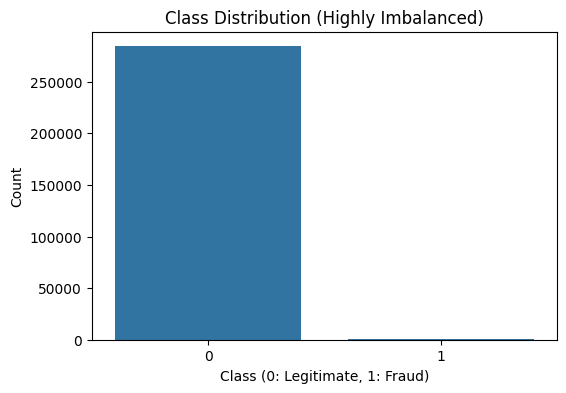

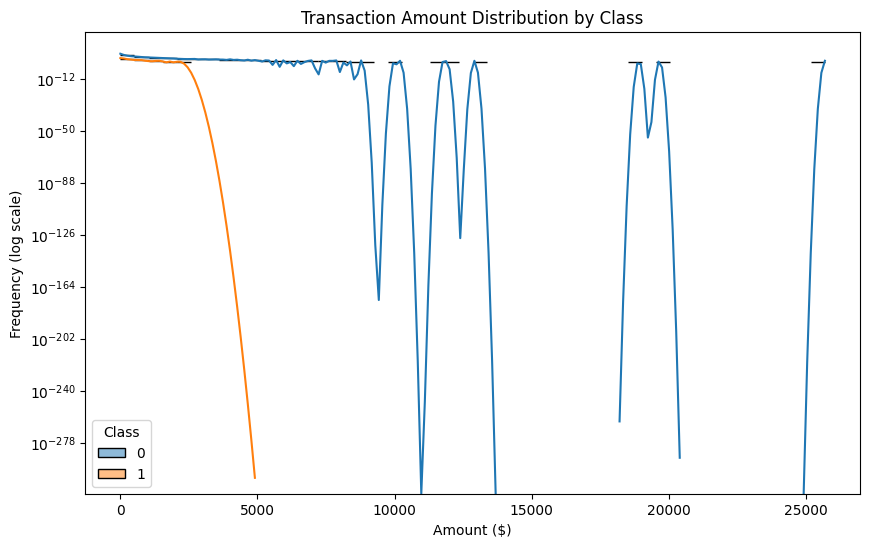

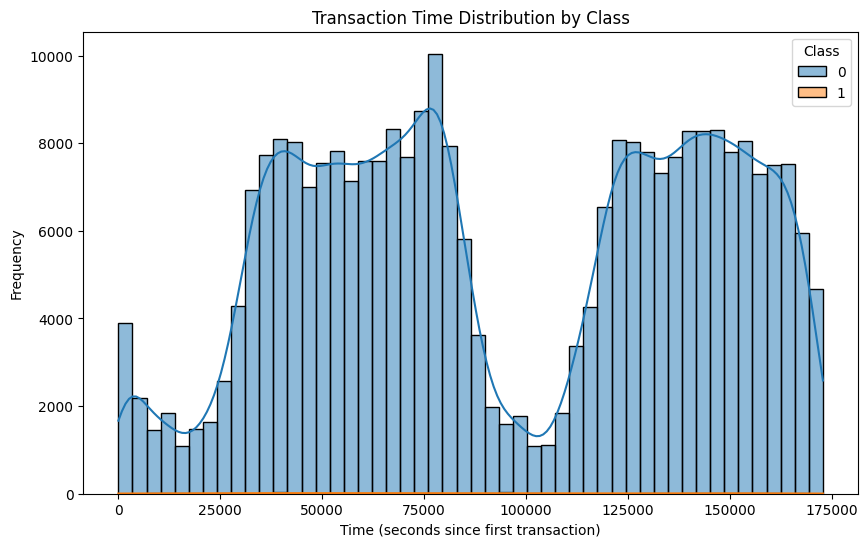

Top correlations with Class:
 Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64


In [2]:

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (Highly Imbalanced)')
plt.xlabel('Class (0: Legitimate, 1: Fraud)')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Amount', hue='Class', bins=50, kde=True, log_scale=(False, True))
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency (log scale)')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Time', hue='Class', bins=50, kde=True)
plt.title('Transaction Time Distribution by Class')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Frequency')
plt.show()


corr_with_class = df.corr()['Class'].sort_values(ascending=False)
print("Top correlations with Class:\n", corr_with_class.head(10))


In [6]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  
from sklearn.model_selection import train_test_split


X = df.drop('Class', axis=1)
y = df['Class']


scaler = StandardScaler()
X[['Amount', 'Time']] = scaler.fit_transform(X[['Amount', 'Time']])


print("Before scaling - Amount mean/std:", df['Amount'].mean(), df['Amount'].std())
print("After scaling - Amount mean/std:", X['Amount'].mean(), X['Amount'].std())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Original train class distribution:", y_train.value_counts())
print("After SMOTE train distribution:", y_train_sm.value_counts())

Before scaling - Amount mean/std: 88.34961925093134 250.12010924018855
After scaling - Amount mean/std: -3.6723778103728753e-17 1.000001755579451
Original train class distribution: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE train distribution: Class
0    227451
1    227451
Name: count, dtype: int64


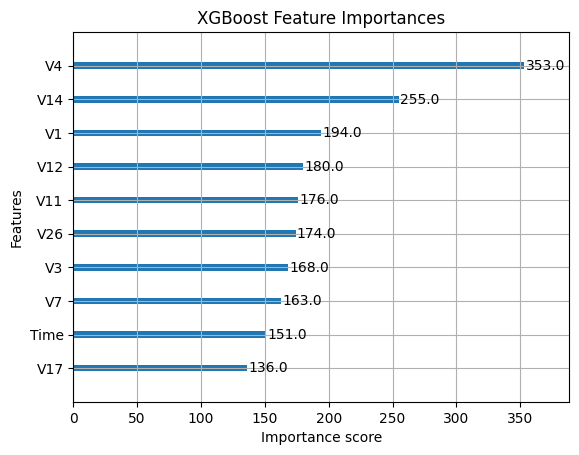

In [7]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb  
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)


xgb_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42)

xgb_model.fit(X_train_sm, y_train_sm)


y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb.plot_importance(xgb_model, max_num_features=10)
plt.title('XGBoost Feature Importances')
plt.show()


Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

AUC-ROC: 0.9721669425367221


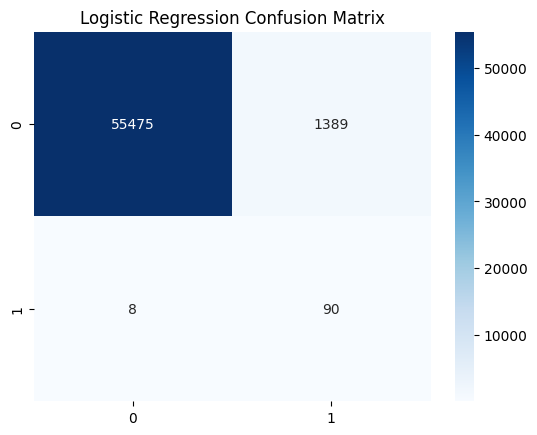


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.46      0.86      0.60        98

    accuracy                           1.00     56962
   macro avg       0.73      0.93      0.80     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9776956189059754


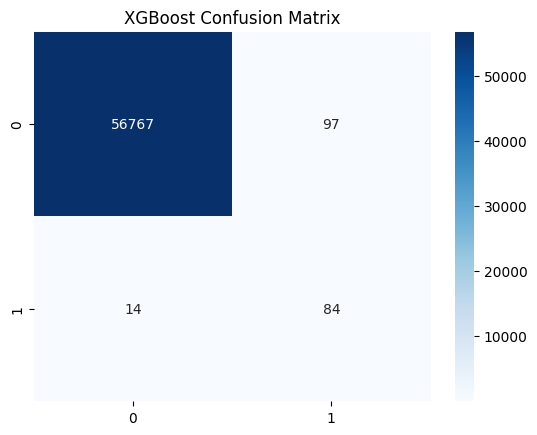

In [8]:

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_xgb))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()



In [9]:
from sklearn.model_selection import GridSearchCV


param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 9], 'learning_rate': [0.1, 0.2]}
grid_xgb = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42), param_grid, cv=3, scoring='f1')
grid_xgb.fit(X_train_sm, y_train_sm)
print("Best XGBoost params:", grid_xgb.best_params_)  


best_xgb = grid_xgb.best_estimator_
y_pred_final = best_xgb.predict(X_test)
y_prob_final = best_xgb.predict_proba(X_test)[:, 1]

print("Final XGBoost Results:")
print(classification_report(y_test, y_pred_final))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_final))


sample_idx = 0
sample_features = X_test.iloc[sample_idx]
sample_pred = y_pred_final[sample_idx]
sample_prob = y_prob_final[sample_idx]
print(f"Sample {sample_idx}: Features (e.g., Amount: {sample_features['Amount']:.2f}), Predicted Class: {sample_pred}, Fraud Probability: {sample_prob:.3f}")


Best XGBoost params: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Final XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.61      0.87      0.72        98

    accuracy                           1.00     56962
   macro avg       0.81      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.9757575001722691
Sample 0: Features (e.g., Amount: -0.26), Predicted Class: 0, Fraud Probability: 0.000


In [10]:
import joblib  

joblib.dump(best_xgb, 'best_xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved!")

Model and scaler saved!


In [11]:
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler


best_xgb = joblib.load('best_xgb_model.pkl')
scaler = joblib.load('scaler.pkl')


feature_names = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

print("Welcome to the Credit Card Fraud Predictor!")
print("Enter values for each feature (use real numbers; Amount in dollars, Time in seconds).")
print("Note: V1-V28 are PCA-transformed (anonymized); in practice, you'd compute them from raw data.")


user_input = {}
for feature in feature_names:
    value = float(input(f"Enter {feature}: "))
    user_input[feature] = value


input_df = pd.DataFrame([user_input])
input_df[['Amount', 'Time']] = scaler.transform(input_df[['Amount', 'Time']])  


prob = best_xgb.predict_proba(input_df)[0][1]  
pred_class = 1 if prob > 0.5 else 0  


importances = best_xgb.feature_importances_
top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:5]  # Top 5
explanation = f"Top contributing features: {', '.join([f'{feat} ({imp:.3f})' for feat, imp in top_features])}"


print("\n--- Prediction Results ---")
print(f"Predicted Class: {pred_class} (0: Legitimate, 1: Fraud)")
print(f"Fraud Probability: {prob:.4f}")
print(f"Explanation: {explanation}")
if pred_class == 1:
    print("Why fraud? High probability due to patterns in top features (e.g., low V14 often indicates fraud, per EDA).")
else:
    print("Why legitimate? Low probability; features align with normal transactions.")
print("\nEnter new values to predict again, or exit the script.")

Welcome to the Credit Card Fraud Predictor!
Enter values for each feature (use real numbers; Amount in dollars, Time in seconds).
Note: V1-V28 are PCA-transformed (anonymized); in practice, you'd compute them from raw data.


Enter Time:  1402
Enter V1:  0
Enter V2:  20
Enter V3:  25
Enter V4:  30
Enter V5:  16
Enter V6:  78
Enter V7:  90026
Enter V8:  251
Enter V9:  897
Enter V10:  1234
Enter V11:  5689
Enter V12:  1254
Enter V13:  212
Enter V14:  215
Enter V15:  256
Enter V16:  6587
Enter V17:  459
Enter V18:  4567
Enter V19:  1230
Enter V20:  12456
Enter V21:  124
Enter V22:  878
Enter V23:  89874
Enter V24:  12
Enter V25:  10
Enter V26:  20
Enter V27:  300
Enter V28:  044
Enter Amount:  410



--- Prediction Results ---
Predicted Class: 0 (0: Legitimate, 1: Fraud)
Fraud Probability: 0.0000
Explanation: Top contributing features: V4 (0.106), V26 (0.085), V1 (0.084), V14 (0.078), V7 (0.055)
Why legitimate? Low probability; features align with normal transactions.

Enter new values to predict again, or exit the script.
